In [324]:
import json, glob
from urllib.parse import urlparse
from collections import Counter

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import combinations

In [325]:
DATA_DIR = "/Users/wnowogorski/PycharmProjects/ChatAGH_DataCollecting/graphs"
MIN_CLUSTER_SIZE = 200
SIM_THRESHOLD = 0.1

Load data

In [326]:
def load_file(file):
    with open(file) as f:
        data = json.load(f)
    df = pd.DataFrame(data["edges"])

    for prefix in (r"^https://", r"www.", r"[\\/]+$"):
        df["source"] = df["source"].str.replace(prefix, "", regex=True)
        df["target"] = df["target"].str.replace(prefix, "", regex=True)

    return df

files = glob.glob(f"{DATA_DIR}/*.json")
graph = pd.concat([load_file(f) for f in files], ignore_index=True)
graph.head()

,source,target
0,http://dzp.agh.edu.pl,agh.edu.pl
1,http://dzp.agh.edu.pl,http://dzp.agh.edu.pl
2,http://dzp.agh.edu.pl,http://dzp.agh.edu.pl/dla-wykonawcow
3,http://dzp.agh.edu.pl,http://dzp.agh.edu.pl/tytul-domyslny/ogloszeni...
4,http://dzp.agh.edu.pl,http://dzp.agh.edu.pl/tytul-domyslny/platforma...


Extract domains from urls

In [327]:
def get_domain(url):
    if not url.startswith(("http://", "https://")):
        url = "http://" + url
    return urlparse(url).netloc

graph['source_domain'] = graph['source'].map(get_domain)
graph['target_domain'] = graph['target'].map(get_domain)

Connections graph details

In [328]:
graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258826 entries, 0 to 258825
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   source         258826 non-null  object
 1   target         258826 non-null  object
 2   source_domain  258826 non-null  object
 3   target_domain  258826 non-null  object
dtypes: object(4)
memory usage: 7.9+ MB


Scraped domains

In [329]:
scraped_domains = list(graph["source_domain"].unique())
scraped_domains

['dzp.agh.edu.pl',
 'podyplomowe.agh.edu.pl',
 'informatyka.podyplomowe.agh.edu.pl',
 'oferta-badawcza.agh.edu.pl',
 'cwp.agh.edu.pl',
 'agh.edu.pl',
 'iet.agh.edu.pl',
 'skos.agh.edu.pl',
 'old.skos.agh.edu.pl',
 'ckim.agh.edu.pl',
 'rownosc.agh.edu.pl',
 'miasteczko.agh.edu.pl',
 'szkolenia.agh.edu.pl',
 'cok.agh.edu.pl',
 'rekrutacja.agh.edu.pl',
 'open.agh.edu.pl',
 'zasoby.open.agh.edu.pl',
 'badap.agh.edu.pl']

Basic stats

In [330]:
unique_urls = graph.groupby("source_domain")["source"].nunique()
connections_count = graph.groupby("source_domain")["target_domain"].count()
internal_connections_count = (
    graph[graph["target_domain"].isin(scraped_domains)]
    .groupby("source_domain")["target_domain"]
    .count()
)
external_connections_count = (
    graph[~graph["target_domain"].isin(scraped_domains)]
    .groupby("source_domain")["target_domain"]
    .count()
)

stats = (
    pd.concat(
        {
            "unique_sources": unique_urls,
            "connections_count": connections_count,
            "external_connections_count": external_connections_count,
            "internal_connections_count": internal_connections_count
        },
        axis=1,
    )
    .fillna(0)
    .astype(int)
)

Number of urls per domain

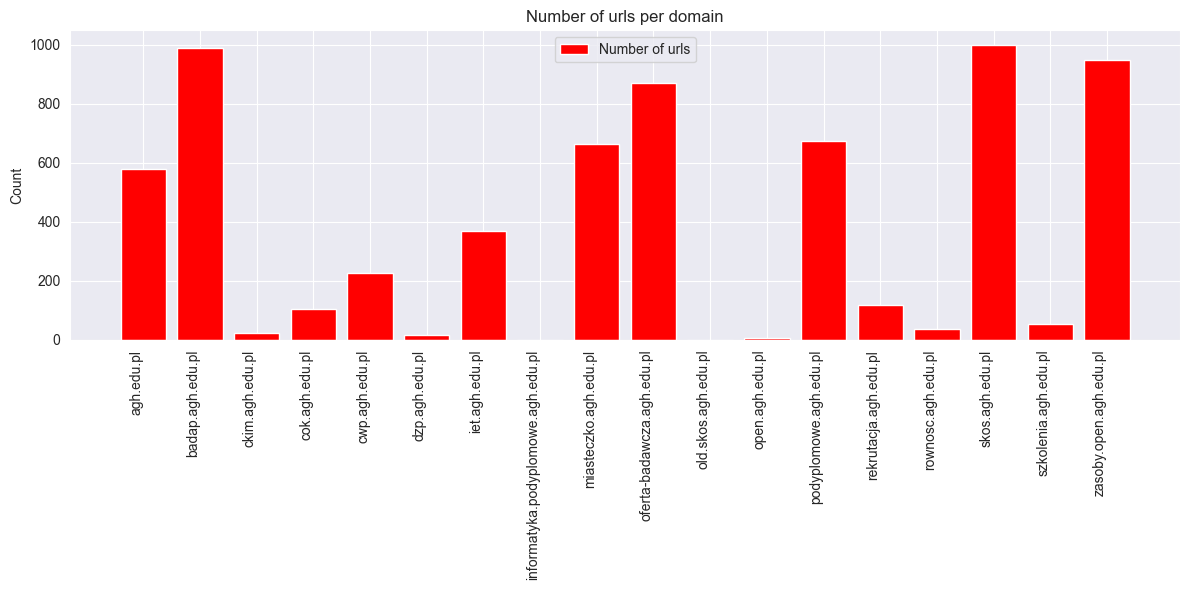

In [331]:
df_plot = stats.copy()
plt.figure(figsize=(12, 6))
x = np.arange(len(df_plot.index))
plt.bar(x, df_plot["unique_sources"], label="Number of urls", color="red")
plt.xticks(x, df_plot.index, rotation=90, ha="right")
plt.ylabel("Count")
plt.title("Number of urls per domain")
plt.legend()
plt.tight_layout()
plt.show()

Number of connections per domain

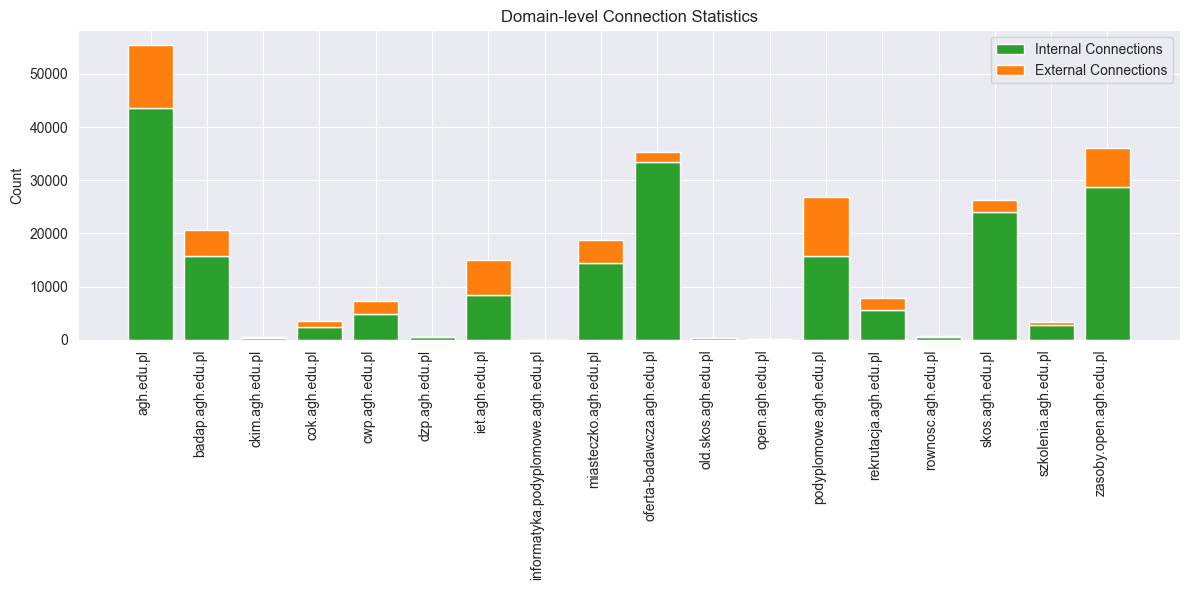

In [332]:
df_plot = stats.copy()
plt.figure(figsize=(12, 6))
x = np.arange(len(df_plot.index))
plt.bar(x, df_plot["internal_connections_count"], label="Internal Connections", color="#2ca02c")
plt.bar(
    x,
    df_plot["external_connections_count"],
    bottom=df_plot["internal_connections_count"],
    label="External Connections",
    color="#ff7f0e"
)
plt.xticks(x, df_plot.index, rotation=90, ha="right")
plt.ylabel("Count")
plt.title("Domain-level Connection Statistics")
plt.legend()
plt.tight_layout()
plt.show()

Cross domain links count

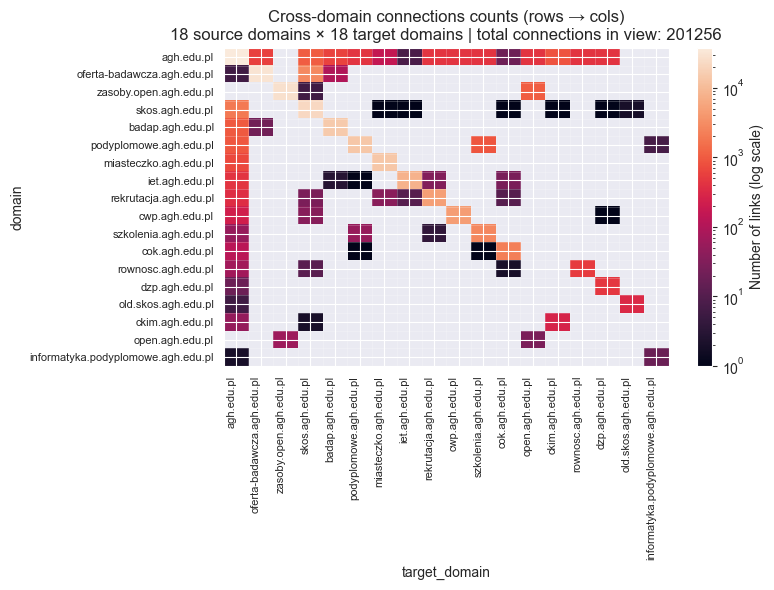

In [333]:
N_ROWS = 40
N_COLS = 40

g = graph.copy()

def extract_domain(s: pd.Series) -> pd.Series:
    s = s.astype("string").str.lower()
    s = s.str.replace(r"^[a-z]+://", "", regex=True)
    s = s.str.replace(r"^www\.", "", regex=True)
    s = s.str.split("/", n=1).str[0]
    s = s.str.split(":", n=1).str[0]
    return s

g["target_domain"] = extract_domain(g["target"])

g = g[g["target_domain"].isin(scraped_domains)]

cross = pd.crosstab(
    g["source_domain"].astype("category"),
    g["target_domain"].astype("category"),
    dropna=True
)

cross_sorted_rows = cross.loc[cross.sum(1).sort_values(ascending=False).index]
cross_sorted = cross_sorted_rows[cross_sorted_rows.sum(0).sort_values(ascending=False).index]

rows = cross_sorted.index[:N_ROWS]
cols = cross_sorted.columns[:N_COLS]
H = cross_sorted.loc[rows, cols].to_numpy()

vmin, vmax = H.min(), H.max()
use_log = vmax > 0 and (vmax / max(vmin, 1)) >= 50
norm = LogNorm(vmin=max(1, H[H>0].min()) if use_log else None, vmax=vmax) if use_log else None

fig_w = max(8, 0.3 * len(cols))
fig_h = max(6, 0.3 * len(rows))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

im = ax.imshow(H, aspect="auto", norm=norm)

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(rows)))
ax.set_xticklabels(cols, rotation=90, ha="right", fontsize=8)
ax.set_yticklabels(rows, fontsize=8)

total_links = int(H.sum())
ax.set_title(f"Cross-domain connections counts (rows → cols)\n"
             f"{len(rows)} source domains × {len(cols)} target domains | total connections in view: {total_links}")
ax.set_xlabel("target_domain")
ax.set_ylabel("domain")

cbar = fig.colorbar(im)
cbar.set_label("Number of links (log scale)" if use_log else "# links", rotation=90)

ax.set_xticks(np.arange(-.5, len(cols), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(rows), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.5, alpha=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

if H.size <= 25:
    for i in range(len(rows)):
        for j in range(len(cols)):
            val = int(H[i, j])
            if val:
                ax.text(j, i, str(val), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

Jaccard similarity between domains. Domains that share many of the same URLs (or subpages) are correlated.

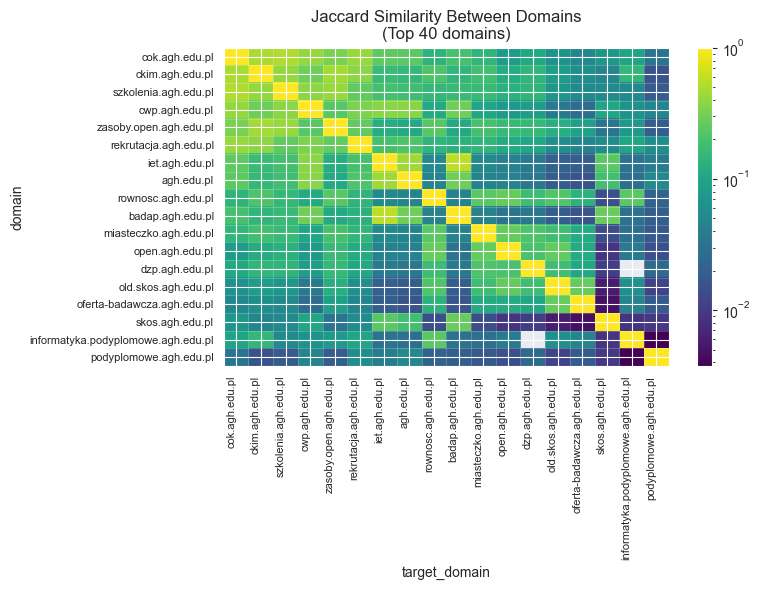

In [334]:
counts = (graph
          .groupby(["source_domain","target_domain"])
          .size()
          .rename("w")
          .reset_index())

bags = {sd: Counter(g.set_index("target_domain")["w"])
        for sd, g in counts.groupby("source_domain")}

domains = list(bags.keys())
n = len(domains)
jac = np.zeros((n,n), float)

for i, j in combinations(range(n), 2):
    Ai, Aj = bags[domains[i]], bags[domains[j]]
    keys = set(Ai) | set(Aj)
    inter = sum(min(Ai[k], Aj[k]) for k in keys)
    union = sum(max(Ai[k], Aj[k]) for k in keys)
    if union:
        v = inter/union
        jac[i,j] = jac[j,i] = v
np.fill_diagonal(jac, 1.0)
jac_df = pd.DataFrame(jac, index=domains, columns=domains)

N = 40
jac_sum = jac_df.sum(axis=1).sort_values(ascending=False)
top_domains = jac_sum.head(N).index
jac_small = jac_df.loc[top_domains, top_domains]

H = jac_small.to_numpy()
use_log = H.max() / max(H[H > 0].min(), 1e-6) > 50
norm = LogNorm(vmin=max(1e-4, H[H > 0].min()) if use_log else None,
               vmax=H.max()) if use_log else None

fig_w, fig_h = max(8, 0.3 * len(top_domains)), max(6, 0.3 * len(top_domains))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

im = ax.imshow(H, cmap="viridis", aspect="auto", norm=norm)

ax.set_xticks(np.arange(len(top_domains)))
ax.set_yticks(np.arange(len(top_domains)))
ax.set_xticklabels(top_domains, rotation=90, ha="right", fontsize=8)
ax.set_yticklabels(top_domains, fontsize=8)

ax.set_title(f"Jaccard Similarity Between Domains\n(Top {N} domains)")
ax.set_xlabel("target_domain")
ax.set_ylabel("domain")

np.fill_diagonal(H, np.nan)
im = ax.imshow(H, cmap="viridis", aspect="auto", norm=norm)
cbar = fig.colorbar(im)

ax.set_xticks(np.arange(-.5, len(top_domains), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(top_domains), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.5, alpha=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

if len(top_domains) <= 10:
    for i in range(len(top_domains)):
        for j in range(len(top_domains)):
            val = H[i, j]
            if val > 0:
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="white")

plt.tight_layout()
plt.show()

Combine interlink strength and node overlap into a weighted similarity graph.

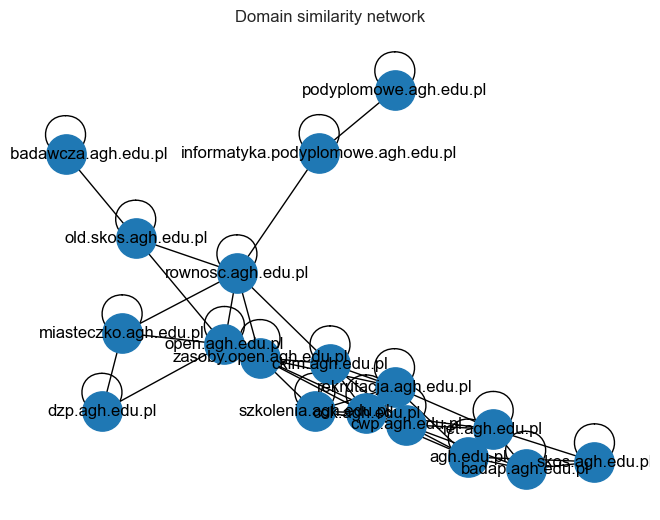

In [335]:
sim = 0.5 * (cross / cross.sum(axis=1).replace(0,1) + jac)
G = nx.from_pandas_adjacency(sim)
G.remove_edges_from([(u,v) for u,v,d in G.edges(data=True) if d['weight'] < SIM_THRESHOLD])
nx.draw(G, with_labels=True, node_size=800)
plt.title("Domain similarity network")
plt.show()

Cluster correlated domains using modularity or connected components.

In [336]:
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G, weight='weight'))
clusters = {}
for i, c in enumerate(communities):
    clusters[i] = c
    count = len(graph[graph["source_domain"].isin(c)]["source"].unique())
    print(f"Cluster {i}: {list(c)},\n\ttotal number of urls: {count}\n")

Cluster 0: ['agh.edu.pl', 'iet.agh.edu.pl', 'cwp.agh.edu.pl', 'badap.agh.edu.pl'],
	total number of urls: 2166

Cluster 1: ['rekrutacja.agh.edu.pl', 'ckim.agh.edu.pl', 'szkolenia.agh.edu.pl', 'cok.agh.edu.pl'],
	total number of urls: 300

Cluster 2: ['dzp.agh.edu.pl', 'miasteczko.agh.edu.pl'],
	total number of urls: 681

Cluster 3: ['old.skos.agh.edu.pl', 'oferta-badawcza.agh.edu.pl'],
	total number of urls: 873

Cluster 4: ['podyplomowe.agh.edu.pl', 'informatyka.podyplomowe.agh.edu.pl'],
	total number of urls: 675

Cluster 5: ['zasoby.open.agh.edu.pl', 'open.agh.edu.pl'],
	total number of urls: 957

Cluster 6: ['rownosc.agh.edu.pl'],
	total number of urls: 36

Cluster 7: ['skos.agh.edu.pl'],
	total number of urls: 999



Save data to json

In [337]:
def get_domain_cluster(domain):
    for cluster_id, domains in clusters.items():
        if domain in domains:
            return cluster_id

graph["cluster"] = graph["source_domain"].apply(get_domain_cluster)
graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258826 entries, 0 to 258825
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   source         258826 non-null  object
 1   target         258826 non-null  object
 2   source_domain  258826 non-null  object
 3   target_domain  258826 non-null  object
 4   cluster        258826 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 9.9+ MB


In [338]:
# clusters = graph["cluster"].unique()
# for cluster in clusters:
#     cluster_df = graph[graph["cluster"] == int(cluster)]
#     cluster_urls = list(cluster_df["source"].unique())
#     json_to_save = {
#         "cluster": int(cluster),
#         "cluster_urls": cluster_urls,
#     }
#     with open(f"cluster_{cluster}.json", "w") as f:
#         json.dump(json_to_save, f)
#
# graph.to_json("graph.json")